In [1]:

CSV_FILE = "CustomerSupportTraining.csv"

import os, re, json, numpy as np, pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

assert os.path.exists(CSV_FILE)


text_col  = "instruction"
label_col = "intent"

df = pd.read_csv(CSV_FILE).copy()
print("", list(df.columns))


df = df[[text_col, label_col]].dropna()
df[text_col]  = df[text_col].astype(str)
df[label_col] = df[label_col].astype(str)

display(df.head(10))
print(df[label_col].value_counts())



 ['flags', 'instruction', 'category', 'intent', 'response']


,instruction,intent
0,question about cancelling order {{Order Number}},cancel_order
1,i have a question about cancelling oorder {{Or...,cancel_order
2,i need help cancelling puchase {{Order Number}},cancel_order
3,I need to cancel purchase {{Order Number}},cancel_order
4,"I cannot afford this order, cancel purchase {{...",cancel_order
5,can you help me cancel order {{Order Number}}?,cancel_order
6,"I can no longer afford order {{Order Number}},...",cancel_order
7,I am trying to cancel purchase {{Order Number}},cancel_order
8,I have got to cancel purchase {{Order Number}},cancel_order
9,i need help canceling purchase {{Order Number}},cancel_order


intent
edit_account                1000
switch_account              1000
check_invoice               1000
complaint                   1000
contact_customer_service    1000
delivery_period              999
registration_problems        999
check_payment_methods        999
contact_human_agent          999
payment_issue                999
newsletter_subscription      999
get_invoice                  999
place_order                  998
cancel_order                 998
track_refund                 998
change_order                 997
get_refund                   997
create_account               997
check_refund_policy          997
review                       997
set_up_shipping_address      997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: count, dtype: int64


In [2]:
import re
from collections import Counter


def simple_tokenize(s):
    return re.findall(r"[A-Za-z0-9']+", s.lower())


train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[label_col]
)


counter = Counter()
for s in train_df[text_col].tolist():
    counter.update(simple_tokenize(s))

max_vocab = 20000
itos = ["<PAD>", "<UNK>"] + [w for w, _ in counter.most_common(max_vocab-2)]
stoi = {w:i for i,w in enumerate(itos)}


classes   = sorted(df[label_col].unique().tolist())
label2id  = {c:i for i,c in enumerate(classes)}
id2label  = {i:c for c,i in label2id.items()}


meta = {
    "text_col": text_col,
    "label_col": label_col,
    "labels": classes,
    "id2label": {str(i):c for i,c in enumerate(classes)},
    "stoi": stoi
}
with open("meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ meta.json")
print("", len(stoi))

✅ meta.json
 2566


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def encode_line(text):
    toks = simple_tokenize(text)
    ids  = [stoi.get(t, 1) for t in toks]  # 1 = <UNK>
    return ids if ids else [1]

class BagDataset(Dataset):
    def __init__(self, df):
        self.x = df[text_col].tolist()
        self.y = [label2id[s] for s in df[label_col].tolist()]
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

def collate_batch(batch):
    token_ids = []
    offsets   = [0]
    ys        = []
    for txt, lab in batch:
        ids = encode_line(txt)
        token_ids.extend(ids)
        offsets.append(offsets[-1] + len(ids))
        ys.append(lab)
    return (torch.tensor(token_ids, dtype=torch.long),
            torch.tensor(offsets[:-1], dtype=torch.long),
            torch.tensor(ys, dtype=torch.long))

train_loader = DataLoader(BagDataset(train_df), batch_size=64, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(BagDataset(val_df),   batch_size=128, shuffle=False, collate_fn=collate_batch)


counts = train_df[label_col].value_counts()
weights = torch.tensor([1.0/max(1, counts[id2label[i]]) for i in range(len(classes))], dtype=torch.float)
weights = weights / weights.mean()

class FastTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim=128):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode='mean')
        self.fc  = nn.Linear(emb_dim, num_labels)
    def forward(self, token_ids, offsets):
        x = self.emb(token_ids, offsets)
        return self.fc(x)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = FastTextClassifier(len(stoi), len(classes), emb_dim=128).to(device)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def evaluate(m, loader):
    m.eval(); correct=0; total=0; loss_sum=0.0
    with torch.no_grad():
        for token_ids, offsets, y in loader:
            token_ids, offsets, y = token_ids.to(device), offsets.to(device), y.to(device)
            logits = m(token_ids, offsets)
            loss = criterion(logits, y)
            loss_sum += loss.item()*y.size(0)
            pred = logits.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return (loss_sum/total, correct/total)

best_acc  = 0.0
best_state = None
EPOCHS = 12  

for ep in range(1, EPOCHS+1):
    model.train()
    for token_ids, offsets, y in train_loader:
        token_ids, offsets, y = token_ids.to(device), offsets.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(token_ids, offsets)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    vl, va = evaluate(model, val_loader)
    print(f"Epoch {ep:02d} | val_loss={vl:.4f} | val_acc={va:.4f}")
    if va > best_acc:
        best_acc = va
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}


torch.save(best_state, "intent-classifier-state.pth")
print("✅  intent-classifier-state.pth（state_dict）")

Epoch 01 | val_loss=0.1792 | val_acc=0.9797
Epoch 02 | val_loss=0.0663 | val_acc=0.9914
Epoch 03 | val_loss=0.0419 | val_acc=0.9933
Epoch 04 | val_loss=0.0313 | val_acc=0.9946
Epoch 05 | val_loss=0.0266 | val_acc=0.9952
Epoch 06 | val_loss=0.0238 | val_acc=0.9952
Epoch 07 | val_loss=0.0222 | val_acc=0.9952
Epoch 08 | val_loss=0.0214 | val_acc=0.9952
Epoch 09 | val_loss=0.0211 | val_acc=0.9952
Epoch 10 | val_loss=0.0210 | val_acc=0.9952
Epoch 11 | val_loss=0.0210 | val_acc=0.9952
Epoch 12 | val_loss=0.0209 | val_acc=0.9952
✅  intent-classifier-state.pth（state_dict）


In [4]:

import json, re, torch
from torch import nn


with open("meta.json","r",encoding="utf-8") as f:
    meta = json.load(f)
labels   = meta["labels"]
id2label = {int(k):v for k,v in meta["id2label"].items()}
stoi     = meta["stoi"]


class FastTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim=128):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode='mean')
        self.fc  = nn.Linear(emb_dim, num_labels)
    def forward(self, token_ids, offsets):
        x = self.emb(token_ids, offsets)
        return self.fc(x)

model = FastTextClassifier(len(stoi), len(labels), emb_dim=128)


try:
    state = torch.load("intent-classifier-state.pth", map_location="cpu", weights_only=True)
except TypeError:
    state = torch.load("intent-classifier-state.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()

def simple_tokenize(s):
    return re.findall(r"[A-Za-z0-9']+", s.lower())

def encode(text):
    ids = [stoi.get(t,1) for t in simple_tokenize(text)]
    if not ids: ids=[1]
    return torch.tensor(ids, dtype=torch.long), torch.tensor([0], dtype=torch.long)

@torch.inference_mode()
def predict(texts):
    out=[]
    for t in texts:
        ids, off = encode(t)
        logits = model(ids, off)
        prob = torch.softmax(logits, dim=1)[0]
        y = int(prob.argmax().item())
        out.append({"text": t, "intent": id2label[y], "confidence": float(prob[y])})
    return out





Classification Report:
                          precision    recall  f1-score   support

            cancel_order     0.9851    0.9950    0.9900       200
            change_order     0.9800    0.9849    0.9825       199
 change_shipping_address     0.9898    0.9949    0.9923       195
  check_cancellation_fee     1.0000    1.0000    1.0000       190
           check_invoice     0.9802    0.9900    0.9851       200
   check_payment_methods     1.0000    1.0000    1.0000       200
     check_refund_policy     1.0000    0.9950    0.9975       199
               complaint     1.0000    1.0000    1.0000       200
contact_customer_service     1.0000    0.9950    0.9975       200
     contact_human_agent     0.9950    0.9950    0.9950       200
          create_account     0.9949    0.9899    0.9924       199
          delete_account     0.9851    1.0000    0.9925       199
        delivery_options     1.0000    1.0000    1.0000       199
         delivery_period     1.0000    1.0000    1.0

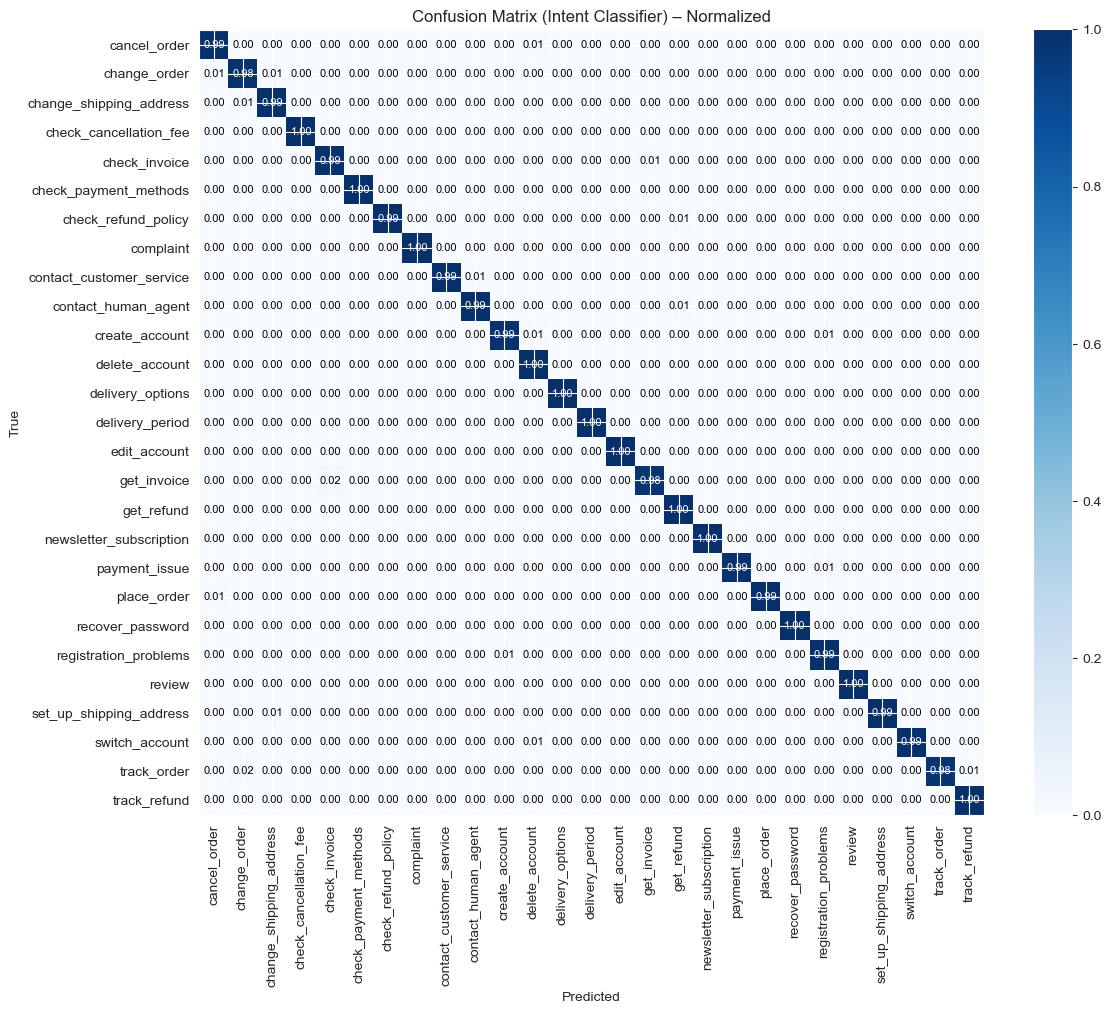

In [5]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = val_df[label_col].tolist()   # label_col = "intent"


preds = predict(val_df[text_col].tolist())   # text_col = "instruction"
y_pred = [p["intent"] for p in preds]

print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm / cm.sum(axis=1, keepdims=True)  

fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(im, ax=ax)

ax.set_title("Confusion Matrix (Intent Classifier) – Normalized")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)


for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        color = "white" if val > 0.5 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color=color)

plt.tight_layout()
plt.show()


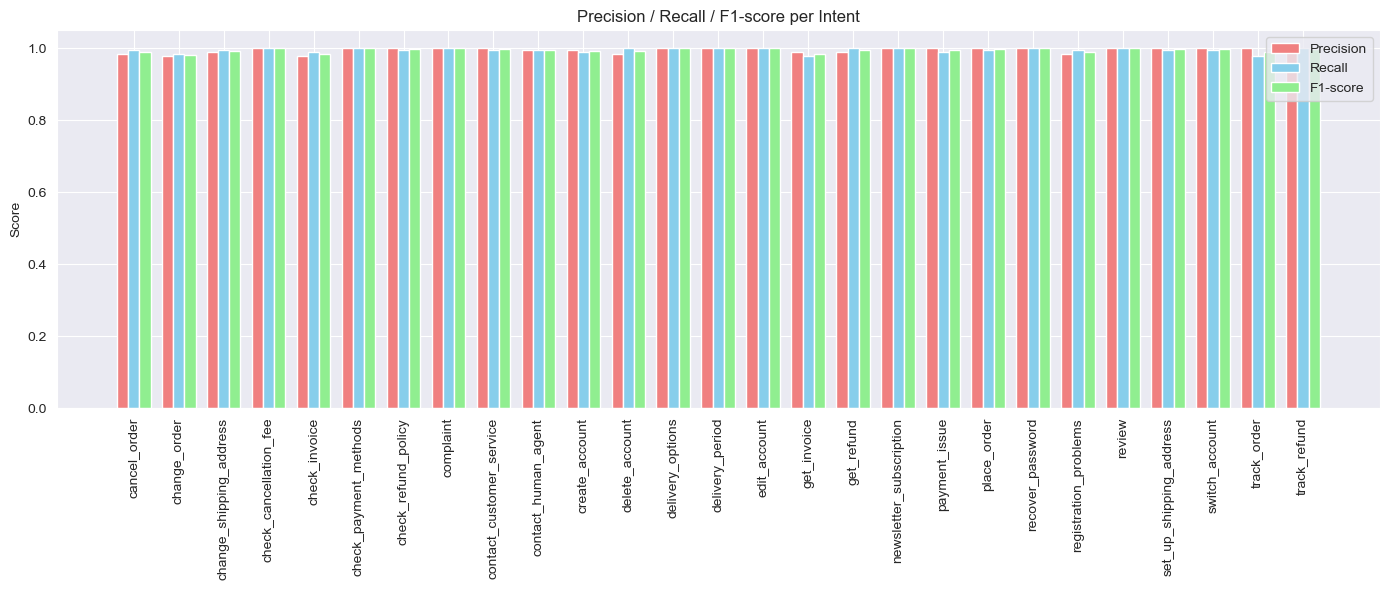

In [6]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np


report = classification_report(y_true, y_pred, labels=labels, output_dict=True)


intent_names = []
precisions, recalls, f1s = [], [], []

for intent in labels:
    if intent in report:
        intent_names.append(intent)
        precisions.append(report[intent]['precision'])
        recalls.append(report[intent]['recall'])
        f1s.append(report[intent]['f1-score'])


x = np.arange(len(intent_names))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, precisions, width, label='Precision', color="lightcoral")
plt.bar(x, recalls, width, label='Recall', color="skyblue")
plt.bar(x + width, f1s, width, label='F1-score', color="lightgreen")


plt.xticks(x, intent_names, rotation=90)
plt.ylim(0,1.05)
plt.ylabel("Score")
plt.title("Precision / Recall / F1-score per Intent")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import os, re, json, random, time
from datetime import datetime

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Config
# ---------------------------
CSV_PATH   = "CustomerSupportTraining.csv"        # CSV must contain: instruction, intent, response
META_PATH  = "meta.json"                           # saved artifacts
STATE_PATH = "intent-classifier-state.pth"         # saved weights
EMB_DIM    = 128
EPOCHS     = 8                                     # quick training epochs if training is needed
BATCH_TRAIN= 64
BATCH_VAL  = 128
THRESHOLD  = 0.60                                  # reply confidence threshold

GREETINGS = [
    "Hello! How can I help you today?",
    "Hi there 👋, what can I do for you?",
    "Welcome! Need any assistance?",
]
FALLBACKS = [
    "Sorry, I didn’t quite understand that. Could you rephrase?",
    "Could you provide a bit more detail?",
]

def simple_tokenize(s: str):
    return re.findall(r"[A-Za-z0-9']+", str(s).lower())

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}. Please place it next to this file.")

df_all = pd.read_csv(CSV_PATH)
required_cols = {"instruction","intent","response"}
if not required_cols.issubset(set(df_all.columns)):
    raise ValueError(f"CSV must contain columns: {sorted(required_cols)}; got: {list(df_all.columns)}")

df_all = df_all[["instruction","intent","response"]].dropna().copy()
df_all["instruction"] = df_all["instruction"].astype(str)
df_all["intent"]      = df_all["intent"].astype(str)
df_all["response"]    = df_all["response"].astype(str)

def make_splits(df, test_size=0.2, seed=42):
    from sklearn.model_selection import train_test_split
    return train_test_split(df, test_size=test_size, random_state=seed, stratify=df["intent"])

intent_groups = {i: g.reset_index(drop=True) for i, g in df_all.groupby("intent")}
intent_to_response = {}
for intent, g in intent_groups.items():
    rs = g["response"].astype(str)
    idx = rs.str.len().idxmax()
    intent_to_response[intent] = rs.loc[idx]

def normalize_instruction(text: str) -> str:
    return re.sub(r"\{\{[^}]+?\}\}", "__PH__", text)

def pick_best_response(intent: str, user_input: str) -> str:
    group = intent_groups.get(intent)
    if group is None or group.empty:
        return intent_to_response.get(intent, "Sorry, I don’t understand your request.")
    user_norm = re.sub(r"\b\d{3,}\b", "__PH__", user_input)
    best_i, best_score = 0, -1.0
    a = set(simple_tokenize(user_norm))
    for i, inst in enumerate(group["instruction"].fillna("").astype(str)):
        inst_norm = normalize_instruction(inst)
        b = set(simple_tokenize(inst_norm))
        score = len(a & b) / (len(a | b) + 1e-9)
        if score > best_score:
            best_score, best_i = score, i
    if best_score >= 0.15:
        return str(group.loc[best_i, "response"])
    return intent_to_response.get(intent, "Sorry, I don’t understand your request.")

class FastTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels, emb_dim=EMB_DIM):
        super().__init__()
        self.emb = nn.EmbeddingBag(vocab_size, emb_dim, mode='mean')
        self.fc  = nn.Linear(emb_dim, num_labels)
    def forward(self, token_ids, offsets):
        return self.fc(self.emb(token_ids, offsets))

def load_or_train():
    if os.path.exists(META_PATH) and os.path.exists(STATE_PATH):
        with open(META_PATH, "r", encoding="utf-8") as f:
            meta = json.load(f)
        labels    = meta["labels"]
        id2label  = {int(k): v for k, v in meta["id2label"].items()}
        stoi      = meta["stoi"]
        model = FastTextClassifier(len(stoi), len(labels))
        try:
            state = torch.load(STATE_PATH, map_location="cpu", weights_only=True)
        except TypeError:
            state = torch.load(STATE_PATH, map_location="cpu")
        model.load_state_dict(state)
        model.eval()
        return model, stoi, labels, id2label

    print("[Info] Artifacts not found. Training a quick model ...")
    from collections import Counter
    train_df, val_df = make_splits(df_all, test_size=0.2, seed=42)
    counter = Counter()
    for s in train_df["instruction"].tolist():
        counter.update(simple_tokenize(s))

    max_vocab = 20000
    itos = ["<PAD>", "<UNK>"] + [w for w,_ in counter.most_common(max_vocab-2)]
    stoi = {w:i for i,w in enumerate(itos)}

    labels = sorted(df_all["intent"].unique().tolist())
    label2id = {c:i for i,c in enumerate(labels)}
    id2label = {i:c for c,i in label2id.items()}

    def encode_line(text):
        toks = simple_tokenize(text)
        ids  = [stoi.get(t,1) for t in toks]
        return ids if ids else [1]

    class BagDataset(Dataset):
        def __init__(self, df):
            self.x = df["instruction"].tolist()
            self.y = [label2id[s] for s in df["intent"].tolist()]
        def __len__(self): return len(self.x)
        def __getitem__(self, i): return self.x[i], self.y[i]

    def collate_batch(batch):
        token_ids, offsets, ys = [], [0], []
        for txt, lab in batch:
            ids = encode_line(txt)
            token_ids.extend(ids)
            offsets.append(offsets[-1] + len(ids))
            ys.append(lab)
        return (torch.tensor(token_ids, dtype=torch.long),
                torch.tensor(offsets[:-1], dtype=torch.long),
                torch.tensor(ys, dtype=torch.long))

    train_loader = DataLoader(BagDataset(train_df), batch_size=64, shuffle=True,  collate_fn=collate_batch)
    val_loader   = DataLoader(BagDataset(val_df),   batch_size=128, shuffle=False, collate_fn=collate_batch)

    counts = train_df["intent"].value_counts()
    weights = torch.tensor([1.0/max(1, counts.get(labels[i], 1)) for i in range(len(labels))], dtype=torch.float)
    weights = weights / weights.mean()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = FastTextClassifier(len(stoi), len(labels)).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    def evaluate(m, loader):
        m.eval(); correct=0; total=0; loss_sum=0.0
        with torch.no_grad():
            for token_ids, offsets, y in loader:
                token_ids, offsets, y = token_ids.to(device), offsets.to(device), y.to(device)
                logits = m(token_ids, offsets)
                loss = criterion(logits, y)
                loss_sum += loss.item()*y.size(0)
                pred = logits.argmax(1)
                correct += (pred==y).sum().item()
                total += y.size(0)
        return (loss_sum/total if total else 0.0, correct/total if total else 0.0)

    for ep in range(1, EPOCHS+1):
        model.train()
        for token_ids, offsets, y in train_loader:
            token_ids, offsets, y = token_ids.to(device), offsets.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(token_ids, offsets)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        vl, va = evaluate(model, val_loader)
        print(f"[Epoch {ep:02d}] val_loss={vl:.4f} val_acc={va:.4f}")

    meta = {
        "labels": labels,
        "id2label": {str(i):c for i,c in enumerate(labels)},
        "stoi": stoi
    }
    with open(META_PATH, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    torch.save({k:v.cpu() for k,v in model.state_dict().items()}, STATE_PATH)
    model.eval()
    print("[Info] Training finished. Artifacts saved.")
    return model, stoi, labels, id2label

model, stoi, labels, id2label = load_or_train()

@torch.inference_mode()
def predict_one(text: str):
    ids = [stoi.get(t,1) for t in simple_tokenize(text)]
    if not ids: ids=[1]
    tok = torch.tensor(ids, dtype=torch.long)
    off = torch.tensor([0], dtype=torch.long)
    logits = model(tok, off)
    prob = torch.softmax(logits, dim=1)[0]
    y = int(prob.argmax().item())
    return id2label[y], float(prob[y].item())



def fill_placeholders(template: str, user_input: str) -> str:
    
    name_match = re.findall(r"\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*", user_input)
    person_name = name_match[-1] if name_match else ""
    last_name = person_name.split()[0] if person_name else ""

    
    amount_match = re.search(r"(RM\s?\d+(?:\.\d{1,2})?|\$\s?\d+(?:\.\d{1,2})?)", user_input, re.IGNORECASE)
    amount = amount_match.group(0) if amount_match else ""

    
    date_match = re.search(r"(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{4}", user_input, re.IGNORECASE)
    date_range = date_match.group(0) if date_match else ""

    replacements = {
        "{{Salutation}}": "Mr." if last_name else "",
        "{{Client Last Name}}": last_name,
        "{{Person Name}}": person_name,
        "{{Date Range}}": date_range,
        "{{Amount}}": amount,
        "$": amount if amount else "$",   
    }

    result = template
    for k, v in replacements.items():
        result = result.replace(k, v)

    
    result = re.sub(r"\{\{[^}]+}}", "", result)
    return result.strip()




EXIT_WORDS = ["bye", "goodbye", "exit", "quit", "see you"]

def bot_reply(user_text: str) -> str:
    text = user_text.strip()
    if not text:
        return random.choice(FALLBACKS)

   
    if text.lower() in EXIT_WORDS:
        return "Goodbye! Have a nice day."

    # 🔹 Greeting
    low = text.lower()
    if any(w in low for w in ["hi", "hello", "hey", "morning", "afternoon", "evening"]):
        return random.choice(GREETINGS)

    
    intent, conf = predict_one(text)
    if conf < THRESHOLD:
        return random.choice(FALLBACKS)

    resp = pick_best_response(intent, text)
    resp = fill_placeholders(resp, text)
    return resp



import tkinter as tk
from tkinter import Frame, Label, Button

class AppChatbot:
    def __init__(self, root):
        self.root = root
        self.root.title("💬 Customer Support Chat")
        self.root.geometry("400x700")
        self.root.configure(bg="#007BFF")
        self.root.resizable(True, True)
        self._build_header()
        self._build_chat_area()
        self._build_input_area()
        self.add_message("👋 Hello! I'm your customer support assistant. How can I help you today?", is_user=False)
    def _build_header(self):
        header = Frame(self.root, bg="#023e8a", height=60)
        header.pack(fill=tk.X)
        header.pack_propagate(False)
        icon = Label(header, text="🤖", font=("Segoe UI", 16), bg="#023e8a", fg="white")
        icon.pack(side=tk.LEFT, padx=15, pady=10)
        title = Frame(header, bg="#023e8a")
        title.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, pady=10)
        Label(title, text="Customer Support", font=("Segoe UI", 13, "bold"),
              bg="#023e8a", fg="white").pack(anchor="w")
        Label(title, text="Online now", font=("Segoe UI", 10),
              bg="#023e8a", fg="#B8E6B8").pack(anchor="w")
    def _build_chat_area(self):
        self.chat_container = Frame(self.root, bg="#ECE5DD")
        self.chat_container.pack(fill=tk.BOTH, expand=True)
        self.canvas = tk.Canvas(self.chat_container, bg="#ECE5DD", highlightthickness=0)
        self.scrollbar = tk.Scrollbar(self.chat_container, orient="vertical", command=self.canvas.yview)
        self.scrollable = Frame(self.canvas, bg="#ECE5DD")
        self.scrollable.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))
        self.canvas.create_window((0, 0), window=self.scrollable, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas.bind("<MouseWheel>", self._on_mousewheel)
        self.root.bind("<MouseWheel>", self._on_mousewheel)
    def _build_input_area(self):
        input_frame = Frame(self.root, bg="#F0F0F0", height=70)
        input_frame.pack(fill=tk.X, side=tk.BOTTOM)
        input_frame.pack_propagate(False)
        box = Frame(input_frame, bg="#FFFFFF", relief="solid", bd=1)
        box.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        self.entry = tk.Text(box, height=2, font=("Segoe UI", 11),
                             bg="#FFFFFF", fg="#333333", relief="flat", bd=0,
                             wrap=tk.WORD, padx=10, pady=8)
        self.entry.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.send_btn = Button(box, text="➤", font=("Segoe UI", 16, "bold"),
                               bg="#25D366", fg="white", relief="flat", bd=0,
                               width=3, command=self._send)
        self.send_btn.pack(side=tk.RIGHT, padx=(5, 10), pady=5)
        self.entry.bind("<Return>", self._enter_send)
        self.entry.bind("<Shift-Return>", lambda e: None)
    def _on_mousewheel(self, event):
        self.canvas.yview_scroll(int(-1 * (event.delta / 120)), "units")
    def _enter_send(self, event):
        self._send()
        return "break"
    def add_message(self, message: str, is_user=False):
        container = Frame(self.scrollable, bg="#ECE5DD")
        container.pack(fill=tk.X, padx=10, pady=5)
        bubble_canvas = tk.Canvas(container, bg="#ECE5DD", highlightthickness=0)
        bubble_color = "#ADE8F4" if is_user else "#F1F1F1"
        side = tk.RIGHT if is_user else tk.LEFT
        pad = (50, 0) if is_user else (0, 50)
        bubble_canvas.pack(side=side, anchor="e" if is_user else "w", padx=pad)
        timestamp = datetime.now().strftime("%H:%M")
        display_text = message + f"  {timestamp}"
        tmp = tk.Label(self.root, text=display_text, font=("Segoe UI", 11), wraplength=250, justify="left")
        tmp.update_idletasks()
        width = min(tmp.winfo_reqwidth() + 24, 270)
        height = tmp.winfo_reqheight() + 16
        tmp.destroy()
        bubble_canvas.configure(width=width, height=height)
        def draw():
            bubble_canvas.delete("all")
            r = 12
            w, h = width, height
            bubble_canvas.create_oval(0, 0, r*2, h, fill=bubble_color, outline="")
            bubble_canvas.create_oval(w - r*2, 0, w, h, fill=bubble_color, outline="")
            bubble_canvas.create_rectangle(r, 0, w - r, h, fill=bubble_color, outline="")
        draw()
        msg_txt = tk.Text(bubble_canvas, font=("Segoe UI", 11), bg=bubble_color,
                          fg="#333333", relief="flat", bd=0, wrap=tk.WORD,
                          cursor="arrow", highlightthickness=0)
        msg_txt.place(x=12, y=8, width=width - 24, height=height - 16)
        msg_txt.insert("1.0", display_text)
        msg_txt.configure(state="disabled")
        self.root.after(50, self._scroll_bottom)
    def _scroll_bottom(self):
        self.canvas.update_idletasks()
        self.canvas.yview_moveto(1.0)
    def _show_typing(self):
        self.typing_holder = Frame(self.scrollable, bg="#ECE5DD")
        self.typing_holder.pack(fill=tk.X, padx=10, pady=5)
        box = Frame(self.typing_holder, bg="#F0F0F0")
        box.pack(side=tk.LEFT, anchor="w", padx=(0, 50))
        tk.Label(box, text="🤖 is typing...", font=("Segoe UI", 11, "italic"),
              bg="#F0F0F0", fg="#666666", padx=12, pady=8).pack()
        self._scroll_bottom()
    def _hide_typing(self):
        if hasattr(self, "typing_holder"):
            self.typing_holder.destroy()
    def _send(self):
        text = self.entry.get("1.0", tk.END).strip()
        if not text:
            return
        self.add_message(text, is_user=True)
        self.entry.delete("1.0", tk.END)
        self._show_typing()
        self.root.after(800, lambda: self._respond(text))
    def _respond(self, text):
        self._hide_typing()
        reply = bot_reply(text)
        self.add_message(reply, is_user=False)

if __name__ == "__main__":
    root = tk.Tk()
    app = AppChatbot(root)
    root.mainloop()
    
